In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [10]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [11]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

In [12]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [13]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    elif(file_extension == '.txt'):
        annotations.append(path + filename + file_extension)

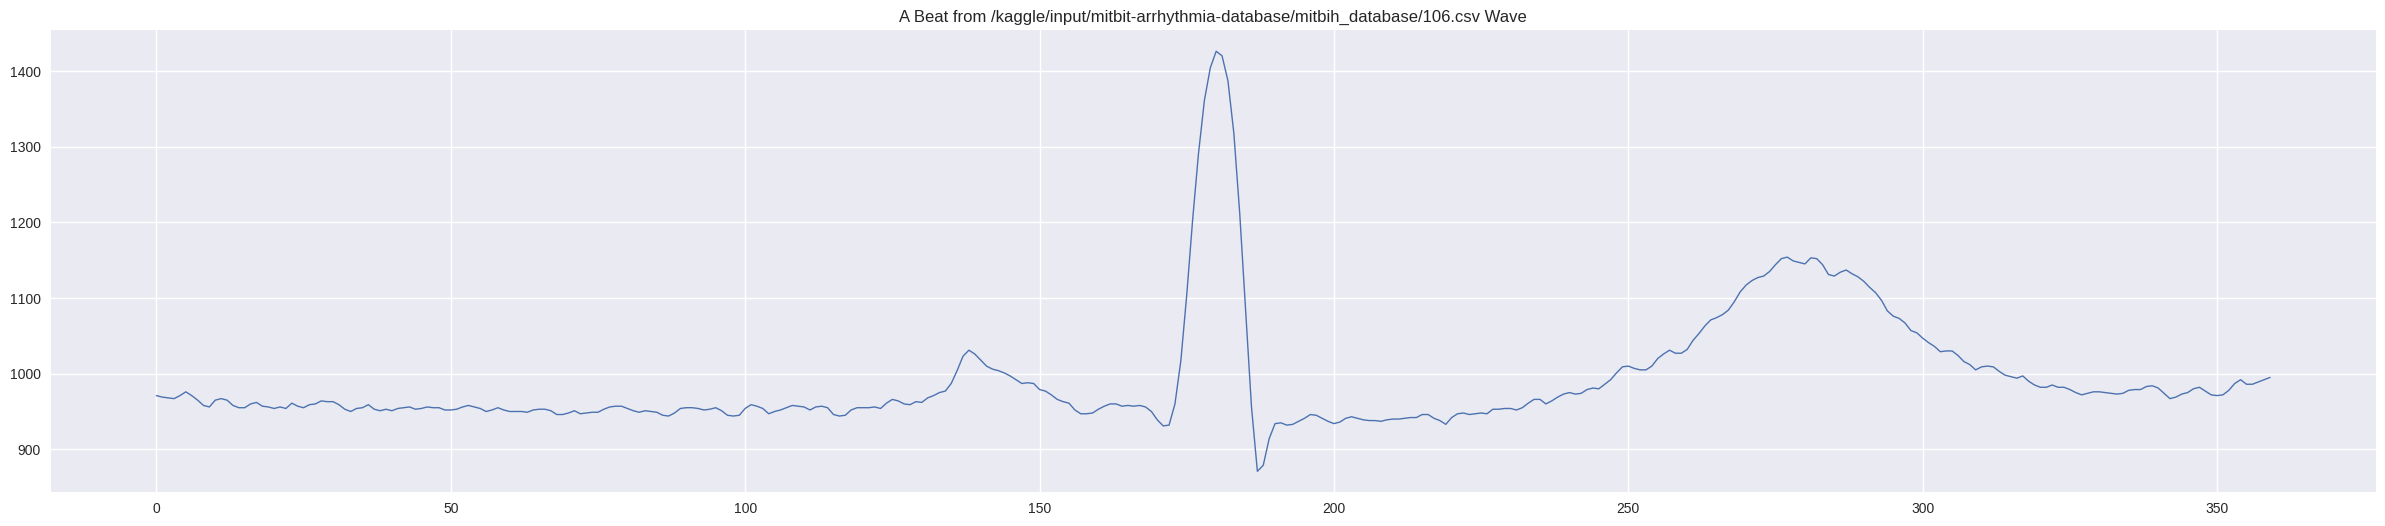

(100012, 360) (100012,)


In [14]:
# Records

X = list()
y = list()

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                #print(row[1])
                signals.insert(row_index, int(float(row[1])))
            row_index += 1
            
    '''# Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
    signals = denoise(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()'''
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.title("A Beat from " + records[6] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [15]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


0    75011
1     8071
2     7255
4     7129
3     2546
Name: 360, dtype: int64


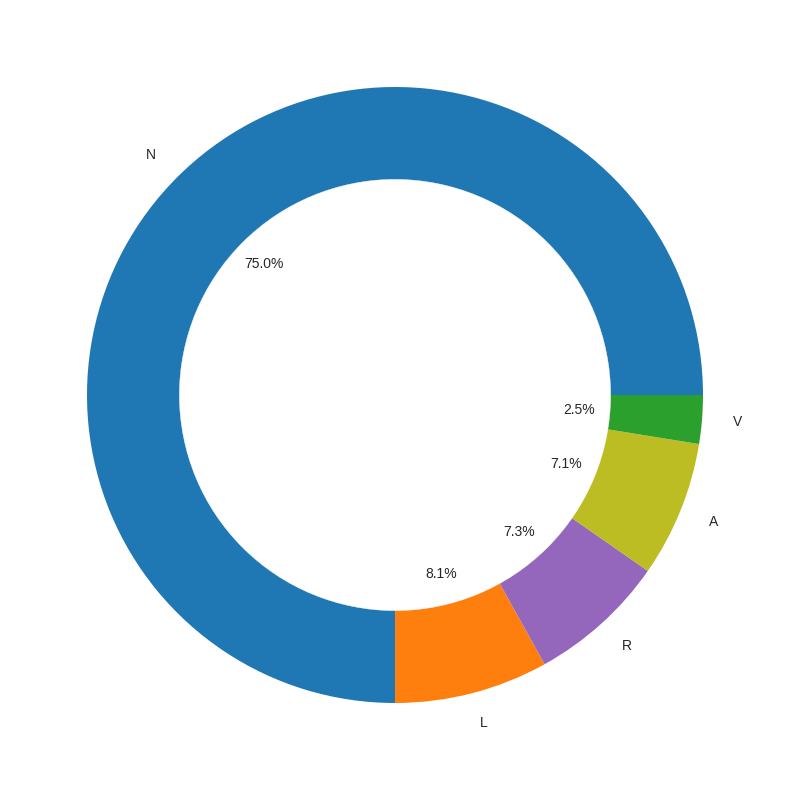

In [16]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [17]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (80009, 361)
X_test  :  (20003, 361)


In [18]:
# train shape = 20000 * 361
# 361 rows and 20000 columns

target_train=train[train.shape[1]-1]

#target_train size is (20000,)


target_test=test[test.shape[1]-1]

#target_test size is 50000


train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(80009, 5) (20003, 5)


In [19]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(80009, 360, 1) (20003, 360, 1)


In [20]:
mitbih_test = test
mitbih_train = train

In [21]:
mitbih_train.shape

(80009, 361)

In [22]:
mitbih_labels = {'N': 0, 'L': 1, 'R': 2, 'A': 3, 'V': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train_labels = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)

Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arhythmia dataset')

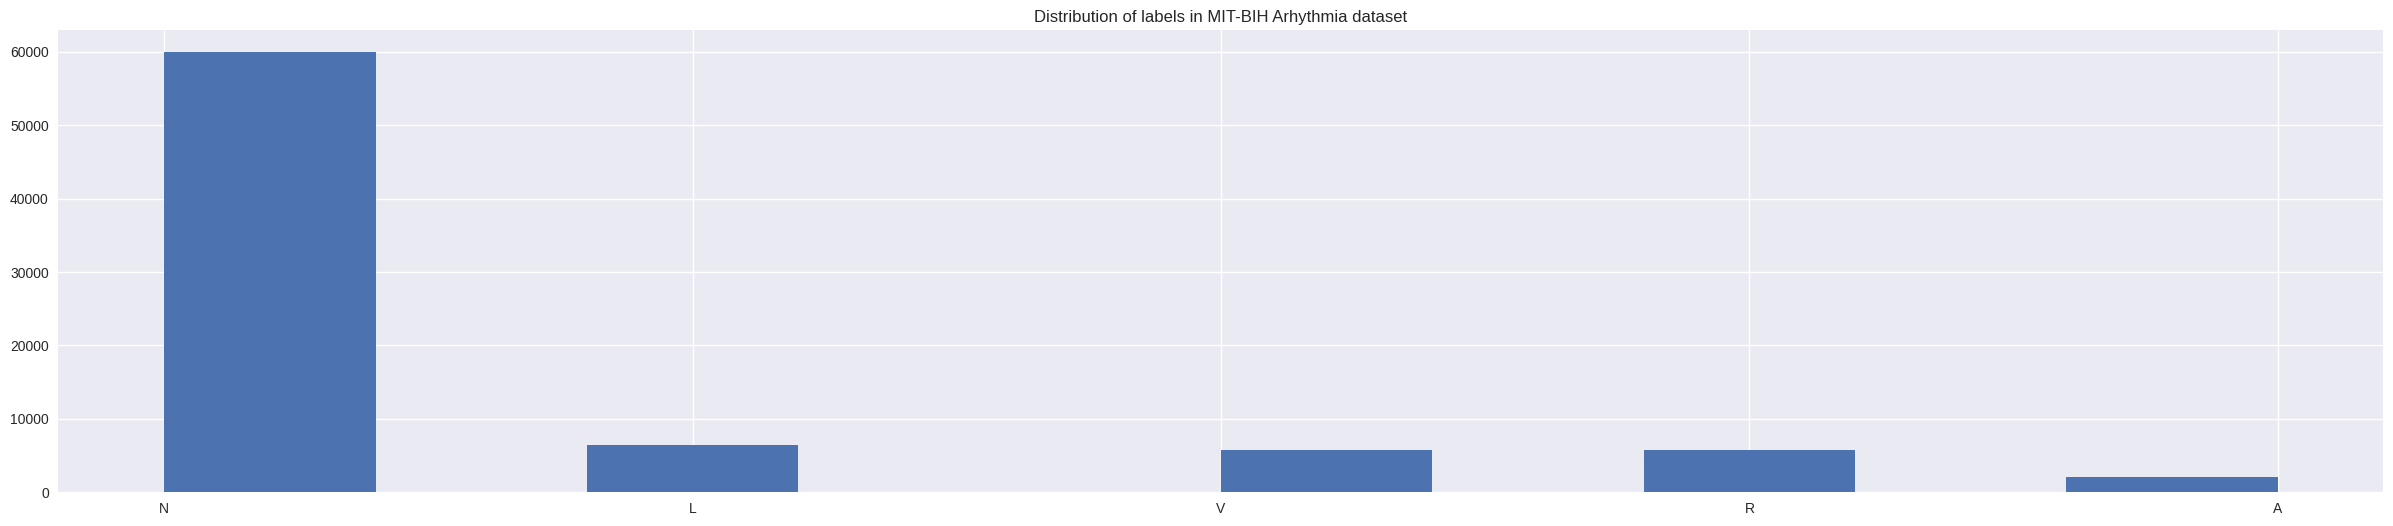

In [23]:
plt.hist(mitbih_train_labels)
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

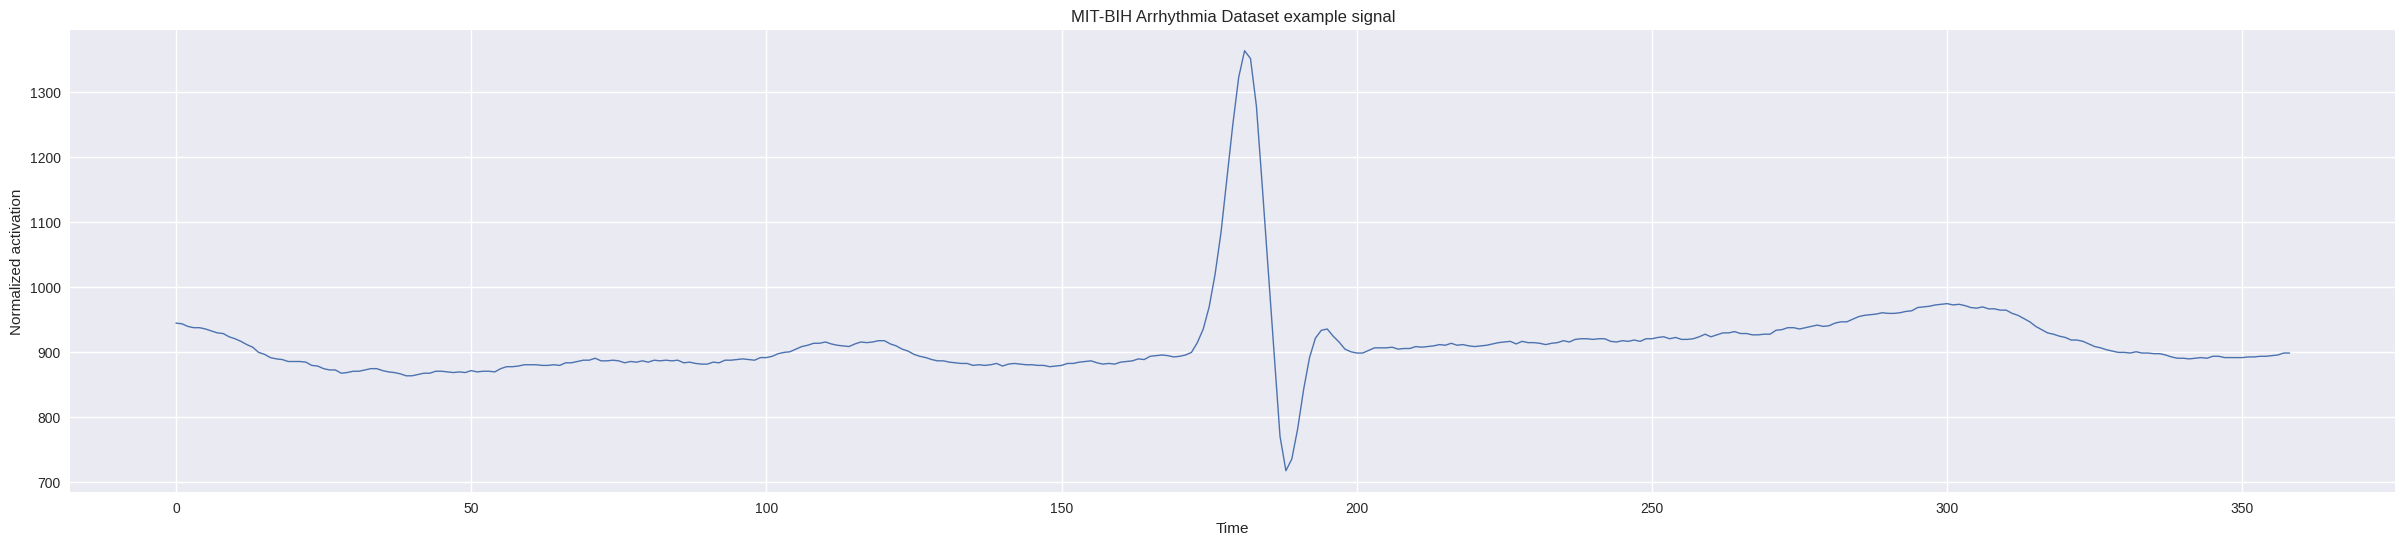

In [24]:
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

In [25]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [26]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

In [27]:
# The 1D convolutions expect an extra dimension in the input data 
X_mitbihl_train = np.expand_dims(X_mitbih_train, -1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

In [32]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPool1D, AveragePooling1D, Flatten, GlobalAveragePooling1D, Dense, Dropout
from keras.layers import concatenate

In [33]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv1D(filters=f1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv1D(filters = f2_conv1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv1D(filters = f2_conv3, kernel_size = 3, padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv1D(filters = f3_conv1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv1D(filters = f3_conv5, kernel_size = 5, padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPool1D(3, strides= 1, padding = 'same')(input_layer)
  path4 = Conv1D(filters = f4, kernel_size = 1, padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [34]:
def GoogLeNet(categories=2):
  # input layer 
    input_layer = keras.layers.Input([360,1])
    #input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv1D(filters = 64, kernel_size = 7, strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPool1D(pool_size = 3, strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
    X = Conv1D(filters = 64, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv1D(filters = 192, kernel_size = 3, padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPool1D(pool_size= 3, strides = 2)(X)

  # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

      # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPool1D(pool_size= 3, strides = 2)(X)

      # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

      # Extra network 1:
    X1 = AveragePooling1D(pool_size = 5, strides = 3)(X)
    X1 = Conv1D(filters = 128, kernel_size = 1, padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
    X2 = AveragePooling1D(pool_size = 5, strides = 3)(X)
    X2 = Conv1D(filters = 128, kernel_size = 1, padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPool1D(pool_size = 3, strides = 2)(X)

      # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

      # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

      # Global Average pooling layer 
    X = GlobalAveragePooling1D(name = 'GAPL')(X)

      # Dropoutlayer 
    X = Dropout(0.4)(X)

      # output layer 
    #X = Dense(1000, activation = 'softmax')(X)
    
    X = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))
      # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

In [ ]:
N = X_mitbih_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_google_model = GoogLeNet(5)

save_google_weights = ModelCheckpoint(filepath="weights_google.hdf5", verbose=0, save_best_only=True)

m_google_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_google = m_google_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=30, callbacks=[save_google_weights])

Epoch 1/30
563/563 [==============================] - 522s 900ms/step - loss: 3.9377 - dense_4_loss: 0.5817 - dense_1_loss: 2.0234 - dense_3_loss: 1.3326 - dense_4_accuracy: 0.8341 - dense_1_accuracy: 0.7827 - dense_3_accuracy: 0.7965 - val_loss: 0.6032 - val_dense_4_loss: 0.1687 - val_dense_1_loss: 0.2596 - val_dense_3_loss: 0.1749 - val_dense_4_accuracy: 0.9485 - val_dense_1_accuracy: 0.9324 - val_dense_3_accuracy: 0.9479
Epoch 2/30
563/563 [==============================] - 500s 889ms/step - loss: 0.5936 - dense_4_loss: 0.1688 - dense_1_loss: 0.2453 - dense_3_loss: 0.1795 - dense_4_accuracy: 0.9522 - dense_1_accuracy: 0.9273 - dense_3_accuracy: 0.9488 - val_loss: 0.4228 - val_dense_4_loss: 0.1570 - val_dense_1_loss: 0.1577 - val_dense_3_loss: 0.1081 - val_dense_4_accuracy: 0.9501 - val_dense_1_accuracy: 0.9558 - val_dense_3_accuracy: 0.9714
Epoch 3/30
563/563 [==============================] - 500s 888ms/step - loss: 0.2241 - dense_4_loss: 0.0566 - dense_1_loss: 0.1034 - dense_3_los

In [ ]:
def pretty_plot(history, field, fn):
    def plot(data, val_data, best_index, best_value, title):
        plt.plot(range(1, len(data)+1), data, label='train')
        plt.plot(range(1, len(data)+1), val_data, label='validation')
        if not best_index is None:
            plt.axvline(x=best_index+1, linestyle=':', c="#777777")
        if not best_value is None:
            plt.axhline(y=best_value, linestyle=':', c="#777777")
        plt.xlabel('Epoch')
        plt.ylabel(field)
        plt.xticks(range(0, len(data), 20))
        plt.title(title)
        plt.legend()
        plt.show()
        
    data = history.history[field]
    val_data = history.history['val_' + field]
    tail = int(0.15 * len(data))
    best_index = fn(val_data)
    best_value = val_data[best_index]
    plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
    plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
pretty_plot(history_google, 'loss', lambda x: np.argmin(x))

In [ ]:
pretty_plot(history_google, 'dense_4_accuracy', lambda x: np.argmax(x))

In [ ]:
m_google_model.load_weights('weights_google.hdf5')
X_mitbih_test = m_google_model.evaluate(X_mitbihl_test, y_mitbihl_test)

In [ ]:
X_mitbihl_test

In [ ]:
N = X_mitbih_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_google_model = GoogLeNet(5)

save_google_weights = ModelCheckpoint(filepath="weights_google.hdf5", verbose=0, save_best_only=True)


In [ ]:
import seaborn as sns

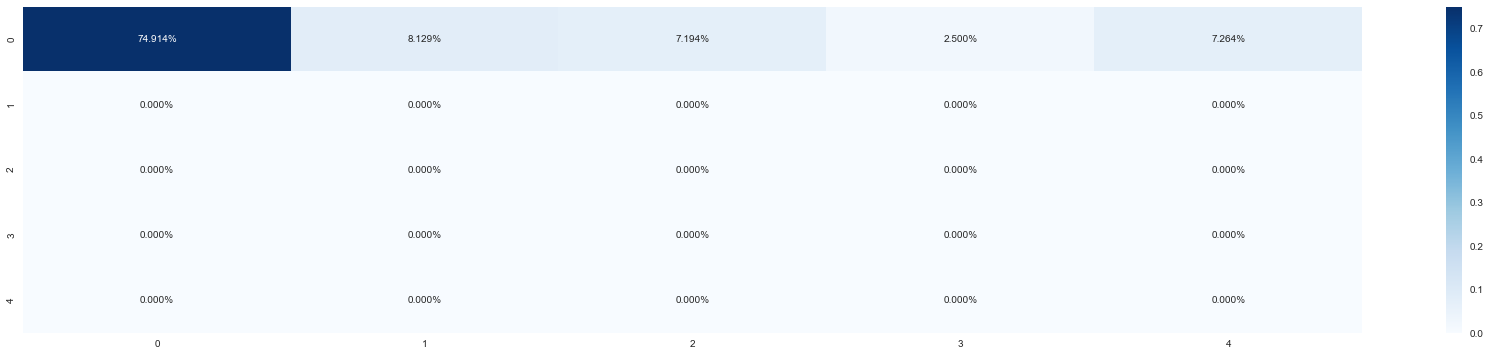

In [29]:
m_google_model.load_weights('weights_google.hdf5')
y_true=[]
for element in y_mitbih_test:
    y_true.append(np.argmax(element))
prediction_proba= m_google_model.predict(X_mitbihl_test)
prediction=np.argmax(prediction_proba[0],axis=-1)

custCnnConfMat = sklearn.metrics.confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat/np.sum(custCnnConfMat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('custCnnconfMat.png')

In [30]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_mitbih_test,prediction))

              precision    recall  f1-score   support



         0.0       1.00      1.00      1.00     14985

         1.0       1.00      1.00      1.00      1626

         2.0       1.00      1.00      1.00      1438

         3.0       0.99      0.98      0.99       503

         4.0       1.00      1.00      1.00      1451



    accuracy                           1.00     20003

   macro avg       1.00      1.00      1.00     20003

weighted avg       1.00      1.00      1.00     20003




In [34]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [36]:
print('Precision: %.3f' % precision_score(y_mitbih_test, prediction, average='macro'))
print('F1 Score: %.3f' % f1_score(y_mitbih_test, prediction, average='macro'))
print('Recall: %.3f' % recall_score(y_mitbih_test, prediction, average='macro'))
#print('Accuracy: %.3f' % accuracy_score(y_mitbih_test, prediction))

Precision: 0.997

F1 Score: 0.997

Recall: 0.996


In [36]:
y_pred1 = tf.argmax(m_google_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix1 = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['N', 'L', 'R', 'A', 'V'],
                      title='Confusion matrix, without normalization')

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [ ]:
m_google_model.summary()